<a href="https://colab.research.google.com/github/Coding-Sorciere/PA_ICW_NWZN6/blob/main/PA_Individual_2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MSIN0097 Predictive Analytics Individual Coursework – Customer Churn Prediction for A Music Streaming Service**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [ ]:
print("Let's help PlaylistPro!")

Let's help PlaylistPro!


**Initial Environment Setup**

This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Setup tools we need later.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Preprocessing

PlaylistPro is a Music Streaming Service.

At PlaylistPro, one of company's top priorities is to reduce customer churn (stop customers from cancelling their subscriptions).

To reduce churn, PlaylistPro plans to reduce the cost of the music streaming service for customers that are likely to cancel their subscription. But, the company currently does not know which customers are likely or unlikely to cancel their subscription.

To help PlaylistPro, I will build a Supervised Classification Model to predict if a customer will churn based on their subscription information and listening habits, based on the 'train dataset' provided. In the end, I will apply the best performed model to the 'test dataset' provided, to make predictions on the new data.  

Training dataset and testing dataset are provided separately and can be accessed via Google Drive. To train the model and validate, review and compare performance, I will split the 'train data' by 80:20, in which 80% of sets being used to train models and 20% used to test the performance. To avoid misunderstanding, I will refer to these 20% split of train data as 'validation data' in later codes and markdowns.

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data():
    train_path = Path("/content/drive/My Drive/PA Individual/train.csv")
    test_path = Path("/content/drive/My Drive/PA Individual/test.csv")

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    print("Datasets loaded successfully!")
    return train_df, test_df

train_df, test_df = load_data()

Datasets loaded successfully!


## Exploratory Data Analysis (EDA)

1. Understand the Dataset Structure

I check data types and non-null counts and identify categorical and numerical features.
Also, I detect missing values.

In [ ]:
train_df.head()

,customer_id,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,1,32,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,2,64,New Jersey,Free,Monthly,3,Paypal,Low,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,1
2,3,51,Washington,Premium,Yearly,2,Credit Card,High,-348,15.400312,24.703696,0.048411,244,117,20,129,50,28,38,0
3,4,63,California,Family,Yearly,4,Apple Pay,Medium,-2894,22.842084,83.595480,0.035691,442,252,47,120,55,17,24,0
4,5,54,Washington,Family,Monthly,3,Paypal,High,-92,23.151163,52.578266,0.039738,243,230,41,66,40,32,47,0


In [ ]:
print("Training Data Info:")
print(train_df.info())

# Check if there is missing values in training data
print("Missing Values in Training Data:")
print(train_df.isnull().sum())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_id                 125000 non-null  int64  
 1   age                         125000 non-null  int64  
 2   location                    125000 non-null  object 
 3   subscription_type           125000 non-null  object 
 4   payment_plan                125000 non-null  object 
 5   num_subscription_pauses     125000 non-null  int64  
 6   payment_method              125000 non-null  object 
 7   customer_service_inquiries  125000 non-null  object 
 8   signup_date                 125000 non-null  int64  
 9   weekly_hours                125000 non-null  float64
 10  average_session_length      125000 non-null  float64
 11  song_skip_rate              125000 non-null  float64
 12  weekly_songs_played         125000 non-null  int64  

2. CLass Distribution of Target Variable (Churn)

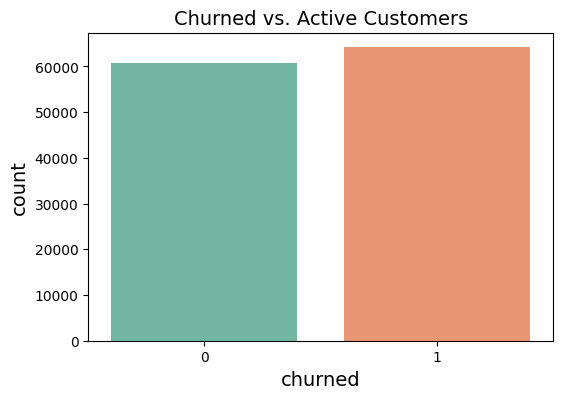

churned
1    0.513392
0    0.486608
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='churned', data=train_df, hue='churned', palette='Set2', legend=False)
plt.title("Churned vs. Active Customers")
plt.show()

# Check if there is class imbalance
print(train_df['churned'].value_counts(normalize=True))

Insights: No class imbalance shows.

3. Numeric Feature Distribution

To detect skewed data and possible transformations.

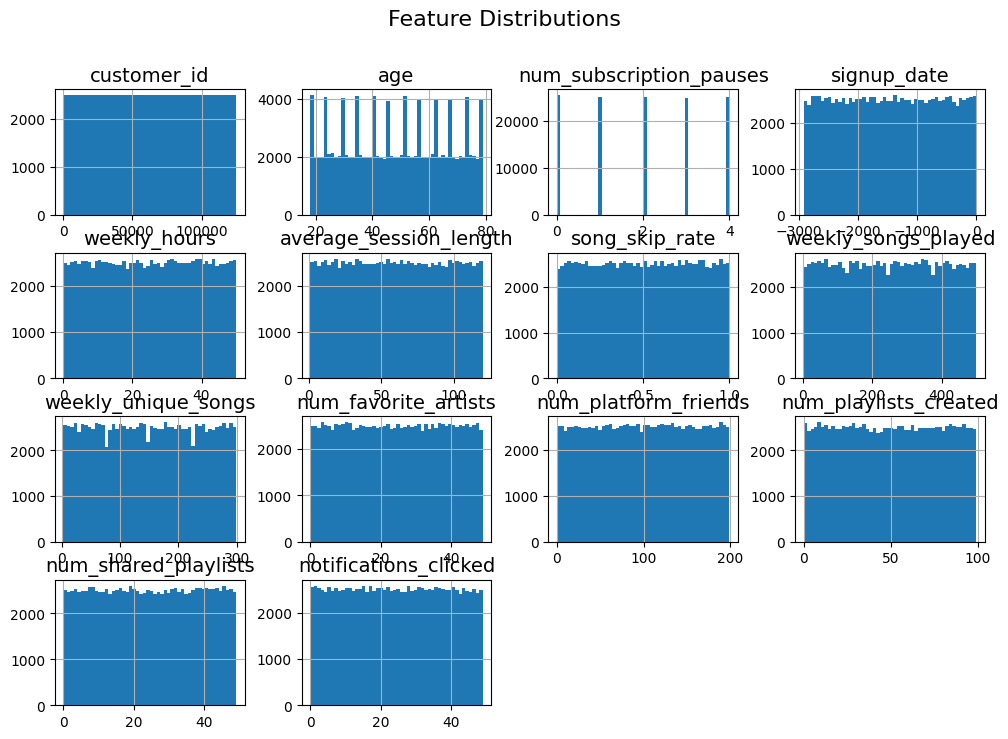

In [ ]:
# Visualizing Numeric Feature Distributions
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('churned')
train_df[numerical_features].hist(figsize=(12, 8), bins=50)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

4. Check Outliers with Boxplots (Tackle ID variable first?)

To identify extreme values in numeric features.

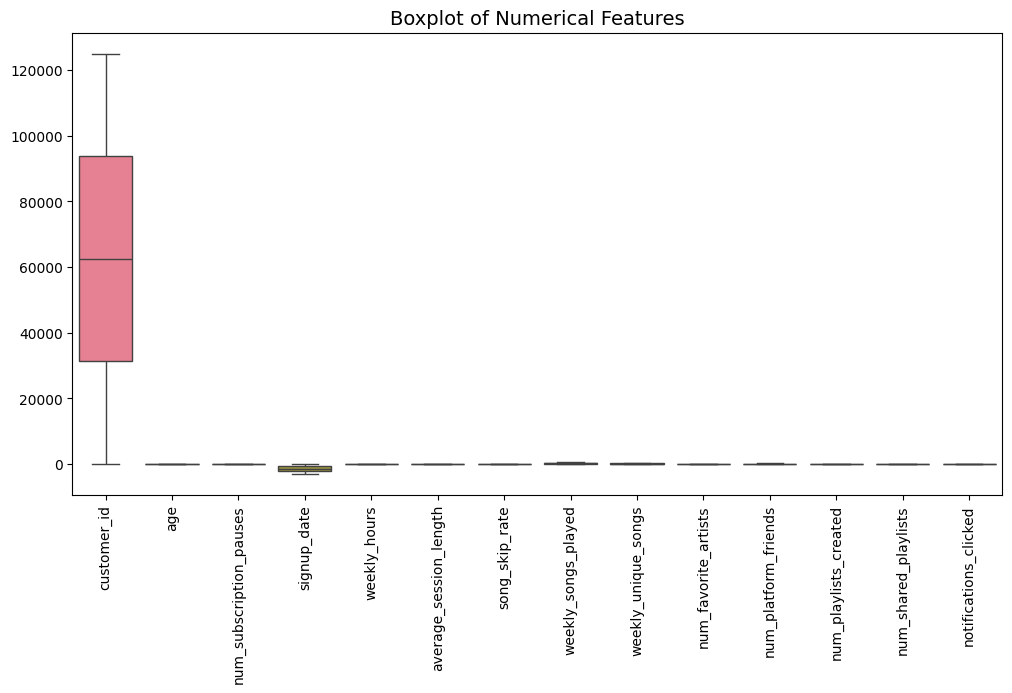

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[numerical_features])
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Features")
plt.show()

5. Check categorical variable distributions



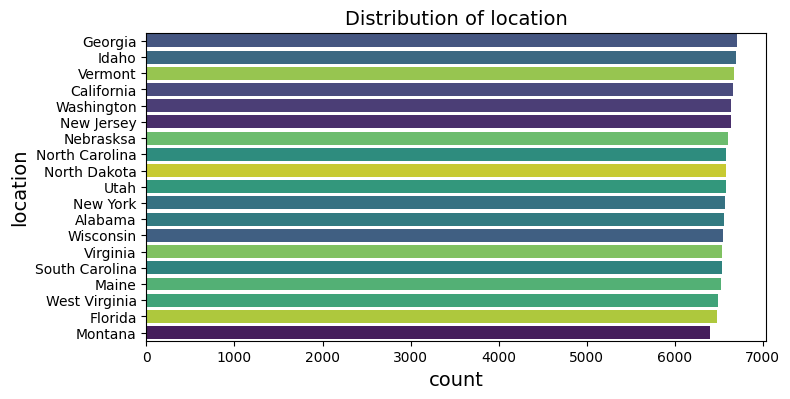

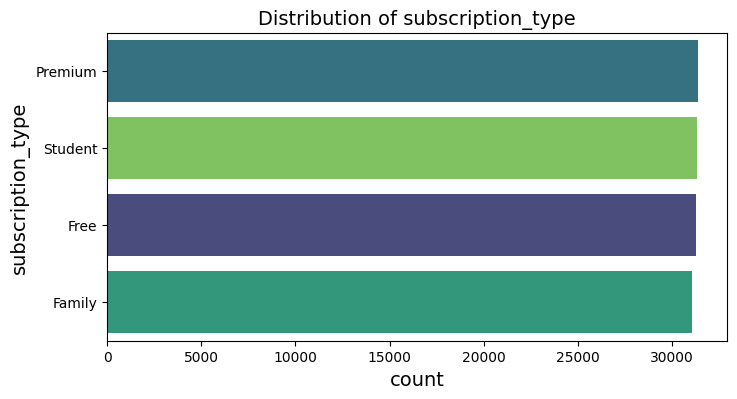

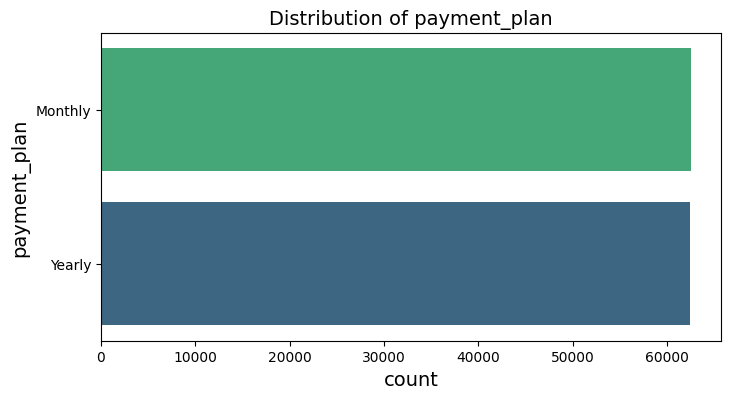

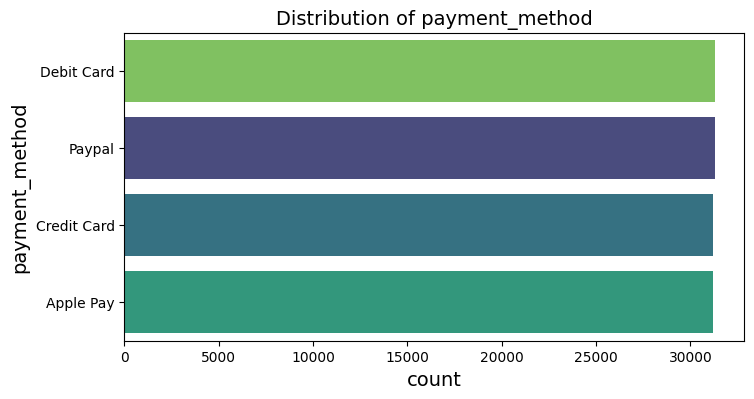

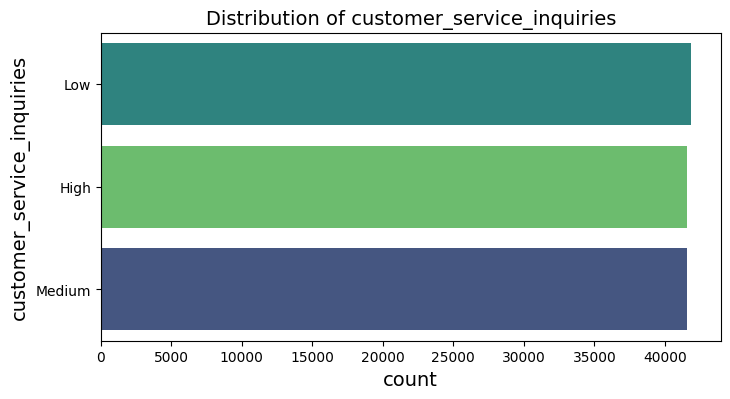

In [ ]:
categorical_features = train_df.select_dtypes(include=['object']).columns
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, hue=train_df[col], palette="viridis", legend=False)
    plt.title(f"Distribution of {col}")
    plt.show()

Insights: It shows a balanced distribution in subscription_type, payment_plan, and payment_method across categories. Also, the customer_service_inquiries feature has evenly distributed categories.

6. Mutual Information to Feature Importance

MI will demonstrate which features are most informative for predicting churn.It measures how much information one variable provides about another, even in non-linear relationships.

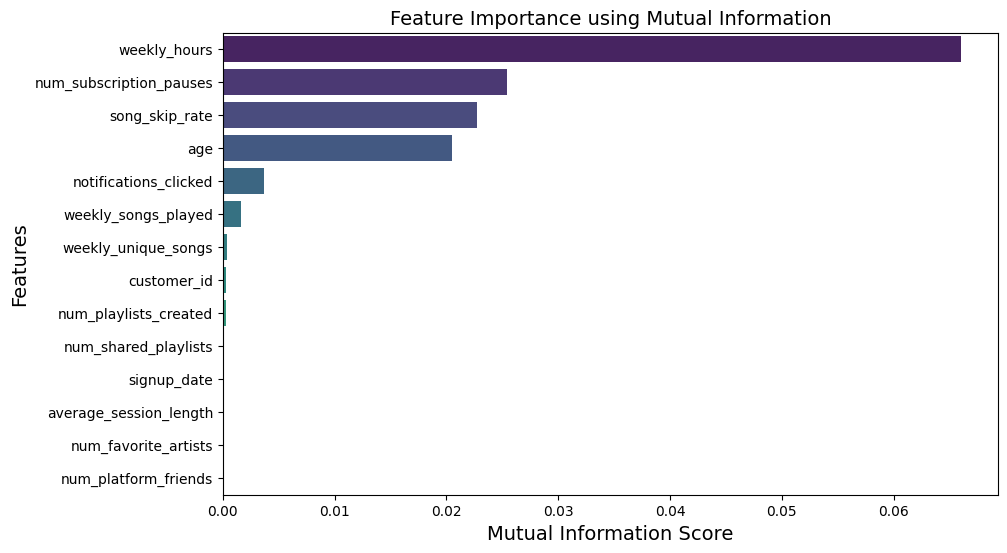

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Compute MI between features and churned (target)
X = train_df.drop(columns=['churned'])
y = train_df['churned']

mi_scores = mutual_info_classif(X.select_dtypes(include=np.number), y, discrete_features=False)
mi_scores = pd.Series(mi_scores, index=X.select_dtypes(include=np.number).columns)
mi_scores.sort_values(ascending=False, inplace=True)

# Plot MI Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores, y=mi_scores.index, hue=mi_scores.index, palette="viridis", legend=False)
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance using Mutual Information")
plt.show()

Insights from MI Score rankings:

1. weekly_hours is the most important feature
This suggests that how much time a user spends on the platform is highly relevant to churn.

2. Users who pause their subscriptions might be at higher risk of churning.

3. song_skip_rate and age also contribute. If users skip songs frequently, they may not be satisfied.

4. Several features have very low importance
num_favorite_artists, num_platform_friends, and customer_tenure show almost no MI score. Consider dropping these if they don't improve models.

# Prepare the Data for Machine Learning Algorithms

1. Handle Missing Values

In [ ]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values.sort_values(ascending=False))

Series([], dtype: int64)


There are no missing values in the dataset.

2. Drop Unnecessary Columns

I identified customer_id as irrelevant for modeling, so remove this variable here.

In [ ]:
train_df.drop(columns=['customer_id'], inplace=True)

3. Transform Numerical Features

As signup_date had negative values, I convert it to customer_tenure and drop signup_date.

In [ ]:
if 'signup_date' in train_df.columns:
    train_df['customer_tenure'] = train_df['signup_date'].abs()  # Convert negative values to positive
    train_df.drop(columns=['signup_date'], inplace=True)

4. Handle Outliers Detected in EDA

As EDA reveals the dataset is fairly distributed, we do not need to handle outliers.

5. Encode Categorical Variables

I identify and convert categorical features into numerical format for modeling.

In [ ]:
categorical_features = train_df.select_dtypes(include=['object']).columns
print("Categorical Features:", categorical_features)

Categorical Features: Index(['location', 'subscription_type', 'payment_plan', 'payment_method',
       'customer_service_inquiries'],
      dtype='object')


I develop different encode methods based on each categorical features.

For 'location', 'subscription_type', 'payment_plan', 'payment_method', I apply One-Hot-Encoding (OHE) because they are nominal variables, without natural rankings or ordinal relationships.

For 'customer_service_inquiries', I apply ordinal encoding, because there is a clear ranking of Low < Medium < High.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Define which columns need One-Hot Encoding (OHE) and which need Ordinal Encoding
ohe_features = ['location', 'subscription_type', 'payment_plan', 'payment_method']
ordinal_features = ['customer_service_inquiries']

# One-Hot Encoding
# Replace 'sparse' with 'sparse_output'
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_encoded = pd.DataFrame(ohe_encoder.fit_transform(train_df[ohe_features]))
ohe_encoded.columns = ohe_encoder.get_feature_names_out(ohe_features)

# Ordinal Encoding
ordinal_mapping = [['Low', 'Medium', 'High']]
ordinal_encoder = OrdinalEncoder(categories=ordinal_mapping)
ordinal_encoded = pd.DataFrame(ordinal_encoder.fit_transform(train_df[ordinal_features]), columns=ordinal_features)

# Drop original categorical columns and merge encoded versions
train_df = train_df.drop(columns=ohe_features + ordinal_features)
train_df = pd.concat([train_df, ohe_encoded, ordinal_encoded], axis=1)

In [ ]:
train_df.head()

,age,num_subscription_pauses,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,...,subscription_type_Free,subscription_type_Premium,subscription_type_Student,payment_plan_Monthly,payment_plan_Yearly,payment_method_Apple Pay,payment_method_Credit Card,payment_method_Debit Card,payment_method_Paypal,customer_service_inquiries
0,32,2,22.391362,105.394516,0.176873,169,109,18,32,52,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,64,3,29.294210,52.501115,0.981811,55,163,44,33,12,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,51,2,15.400312,24.703696,0.048411,244,117,20,129,50,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
3,63,4,22.842084,83.595480,0.035691,442,252,47,120,55,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,54,3,23.151163,52.578266,0.039738,243,230,41,66,40,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0


6. Feature Scaling

Logistic Regression, Neural Networks, k-NNs are sensitive to different feature scales. Therefore we apply StandardScaler() to scale all numerical features.

In [ ]:
# Identify numerical features (excluding target variable)
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('churned')

# Apply MinMaxScaler to numerical features
scaler = MinMaxScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

In [ ]:
train_df.describe()

,age,num_subscription_pauses,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,...,subscription_type_Free,subscription_type_Premium,subscription_type_Student,payment_plan_Monthly,payment_plan_Yearly,payment_method_Apple Pay,payment_method_Credit Card,payment_method_Debit Card,payment_method_Paypal,customer_service_inquiries
count,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,...,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000
mean,0.498592,0.497786,0.500740,0.499355,0.500815,0.499645,0.499268,0.499998,0.501072,0.499576,...,0.250152,0.250832,0.250440,0.500496,0.499504,0.249704,0.249704,0.250336,0.250256,0.498840
std,0.293460,0.354300,0.288950,0.288949,0.288716,0.288967,0.289848,0.294816,0.289856,0.292276,...,0.433102,0.433494,0.433268,0.500002,0.500002,0.432843,0.432843,0.433208,0.433162,0.408549
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.245902,0.250000,0.249453,0.249115,0.250978,0.250000,0.246622,0.244898,0.251256,0.242424,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.491803,0.500000,0.502334,0.498676,0.501175,0.500000,0.496622,0.510204,0.502513,0.494949,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,0.754098,0.750000,0.751407,0.749888,0.751131,0.750000,0.750000,0.755102,0.753769,0.757576,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## No Need to Split, Preprocess Test Dataset Instead

The datasets accessed contain separate training and testing dataset, thus there is no need to split in this case.

Here I apply the same transformation to the test dataset provided.

In [ ]:
# Drop customer_id
test_df.drop(columns=['customer_id'], inplace=True)

# Convert signup_date to customer_tenure
if 'signup_date' in test_df.columns:
    test_df['customer_tenure'] = test_df['signup_date'].abs()
    test_df.drop(columns=['signup_date'], inplace=True)

# Encode categorical features
test_ohe_encoded = pd.DataFrame(ohe_encoder.transform(test_df[ohe_features]))
test_ohe_encoded.columns = ohe_encoder.get_feature_names_out(ohe_features)

test_ordinal_encoded = pd.DataFrame(ordinal_encoder.transform(test_df[ordinal_features]), columns=ordinal_features)

test_df = test_df.drop(columns=ohe_features + ordinal_features)
test_df = pd.concat([test_df, test_ohe_encoded, test_ordinal_encoded], axis=1)

# Apply the SAME SCALER from train_df to test_df
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

print("Test dataset preprocessing and scaling completed successfully!")

Test dataset preprocessing and scaling completed successfully!


In [ ]:
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)

missing_in_test = train_columns - test_columns
extra_in_test = test_columns - train_columns

print("Missing in test_df:", missing_in_test)
print("Extra in test_df:", extra_in_test)

Missing in test_df: {'churned'}
Extra in test_df: set()


Except for the predicting feature (target variable) 'churned', everything else in test dataset matches with train dataset. Good.

## Custom Transformers

Based on our EDA insights, potential transformations include:



*   Creating new features (e.g., engagement_score = weekly_hours * song_skip_rate).
*   Binning numerical values (e.g., categorise customer_tenure into groups: New, Regular, Loyal).
*   Transforming skewed features (e.g., log-transform for weekly_hours).


Now I create a custom transformer class using scikit-learn's TransformerMixin.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, log_transform_features=None):
        self.log_transform_features = log_transform_features if log_transform_features else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Apply log transformation
        for feature in self.log_transform_features:
            X_transformed[feature] = X_transformed[feature].apply(lambda x: np.log1p(max(x, 0)))

        return X_transformed

Next, I define which features to transform，and apply the custom transformer to training and testing datasets.

In [ ]:
# Features to log-transform
log_features = ['weekly_hours', 'song_skip_rate', 'num_playlists_created', 'notifications_clicked']

# Apply Custom Transformer to the full training dataset
transformer = CustomFeatureTransformer(log_transform_features=log_features)
train_df_transformed = transformer.fit_transform(train_df)

# Apply the same transformation to `test_df`
test_df_transformed = transformer.transform(test_df)

print("Custom transformations applied successfully!")

Custom transformations applied successfully!


After applying transformation, some encoded categorical variables (subscription_type_Free, payment_method_Paypal) show very small negative values. I should clip values to ensure all one-hot encoded features remain between [0,1]

In [ ]:
# Identify numerical columns separately for each dataset
numerical_features_train = train_df_transformed.select_dtypes(include=['int64', 'float64']).columns.drop('churned')
numerical_features_test = test_df_transformed.select_dtypes(include=['int64', 'float64']).columns  # No 'churned' in test set

# Apply Clipping Only to Numerical Features
train_df_transformed[numerical_features_train] = train_df_transformed[numerical_features_train].clip(lower=0)
test_df_transformed[numerical_features_test] = test_df_transformed[numerical_features_test].clip(lower=0)

print("Converted categorical features and applied clipping successfully!")

Converted categorical features and applied clipping successfully!


## Transformation Pipelines

 I here build a pipeline to preprocess the numerical attributes.

 This will contribute to a better result as it ensures all preprocessing steps are applied consistently, avoids data leakage by fitting transformations only on training data, and simplifies model deployment, make it possible to be used for new data.

 Here I combine the following steps into a Pipeline:

Numerical Feature Scaling → StandardScaler

*   Log Transformations → Custom Transformer
*   One-Hot Encoding for categorical variables
*   Ordinal Encoding for customer_service_inquiries

In [ ]:
print("Columns in train_df:", train_df.columns)

Columns in train_df: Index(['age', 'num_subscription_pauses', 'weekly_hours',
       'average_session_length', 'song_skip_rate', 'weekly_songs_played',
       'weekly_unique_songs', 'num_favorite_artists', 'num_platform_friends',
       'num_playlists_created', 'num_shared_playlists',
       'notifications_clicked', 'churned', 'customer_tenure',
       'location_Alabama', 'location_California', 'location_Florida',
       'location_Georgia', 'location_Idaho', 'location_Maine',
       'location_Montana', 'location_Nebrasksa', 'location_New Jersey',
       'location_New York', 'location_North Carolina', 'location_North Dakota',
       'location_South Carolina', 'location_Utah', 'location_Vermont',
       'location_Virginia', 'location_Washington', 'location_West Virginia',
       'location_Wisconsin', 'subscription_type_Family',
       'subscription_type_Free', 'subscription_type_Premium',
       'subscription_type_Student', 'payment_plan_Monthly',
       'payment_plan_Yearly', 'payment_m

In [ ]:
# Define feature categories
numerical_features = ['age', 'num_subscription_pauses', 'weekly_hours', 'average_session_length',
                      'song_skip_rate', 'weekly_songs_played', 'weekly_unique_songs',
                      'num_favorite_artists', 'num_platform_friends', 'num_playlists_created',
                      'customer_tenure', 'customer_service_inquiries']

categorical_features = [ ]
ordinal_features = [ ]

# Custom transformer for log transformation
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, log_transform_features=None):
        self.log_transform_features = log_transform_features if log_transform_features else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Apply log transformation
        for feature in self.log_transform_features:
            X_transformed[feature] = X_transformed[feature].apply(lambda x: np.log1p(max(x, 0)))

        return X_transformed

In [ ]:
from sklearn.impute import SimpleImputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', MinMaxScaler())  # Normalize values
])

# Define transformations
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features),
])

In [ ]:
# Complete processing pipeline
full_pipeline = Pipeline(steps=[
    ('custom_transform', CustomFeatureTransformer(
        log_transform_features=['weekly_hours', 'song_skip_rate', 'num_playlists_created', 'notifications_clicked'])),
    ('preprocessor', preprocessor)
])

# Apply pipeline
X_train_transformed = full_pipeline.fit_transform(train_df.drop(columns=['churned'], errors='ignore'))
X_test_transformed = full_pipeline.transform(test_df)

# Convert transformed data to DataFrame
X_train_transformed = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())

print("Pipeline applied successfully! Preprocessed datasets are ready for model training.")

Pipeline applied successfully! Preprocessed datasets are ready for model training.


**Basic Feature Scaling**

In [ ]:
print("Checking for NaN values before scaling:")
print(X_train_transformed.isnull().sum().sum())  # Total NaNs
print("Columns with NaNs:")
print(X_train_transformed.isnull().sum())

Checking for NaN values before scaling:
0
Columns with NaNs:
num__age                           0
num__num_subscription_pauses       0
num__weekly_hours                  0
num__average_session_length        0
num__song_skip_rate                0
num__weekly_songs_played           0
num__weekly_unique_songs           0
num__num_favorite_artists          0
num__num_platform_friends          0
num__num_playlists_created         0
num__customer_tenure               0
num__customer_service_inquiries    0
dtype: int64


Checking get_feature_names_out() and shape after the pipeline transformation. This is to ensure:

The transformed dataset has the expected number of features (shape).

The pipeline correctly preserves feature names (get_feature_names_out()).

In [ ]:
print("Shape of transformed training data:", X_train_transformed.shape)
print("Shape of transformed test data:", X_test_transformed.shape)

Shape of transformed training data: (125000, 12)
Shape of transformed test data: (75000, 12)


In [ ]:
feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
print("Transformed Feature Names:")
print(feature_names)

Transformed Feature Names:
['num__age' 'num__num_subscription_pauses' 'num__weekly_hours'
 'num__average_session_length' 'num__song_skip_rate'
 'num__weekly_songs_played' 'num__weekly_unique_songs'
 'num__num_favorite_artists' 'num__num_platform_friends'
 'num__num_playlists_created' 'num__customer_tenure'
 'num__customer_service_inquiries']


# Benchmarking

0. Split Data into Training & Validation Sets (8:2)

In [ ]:
y_train = train_df['churned']
X_train, X_val, y_train, y_val = train_test_split(
    X_train_transformed, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print("Data successfully split into training and validation sets!")

Data successfully split into training and validation sets!


## Train Baseline Models

To establish performance benchmarks for later neural network modeling, here I train 4 baseline models and review their performances.

**1. Logistic Regression**

Logistic Regression is a widely-used linear model that estimates the probability of a binary outcome (e.g., churn or not churn) by applying a logistic (sigmoid) function to a linear combination of the input features.

In [ ]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_val)

# Evaluate Logistic Regression
log_results = {
    "Accuracy": accuracy_score(y_val, y_pred_log),
    "Precision": precision_score(y_val, y_pred_log),
    "Recall": recall_score(y_val, y_pred_log),
    "F1-score": f1_score(y_val, y_pred_log)
}

print("Logistic Regression Performance:")
print(pd.DataFrame([log_results]))

Logistic Regression Performance:
   Accuracy  Precision    Recall  F1-score
0   0.73404   0.744429  0.733931  0.739142


Comments:

The performance shows that Logistic Regression captures a decent linear relationship in the data. Its balanced precision and recall suggest that the model does not overly favour one class. However, its simplicity might limit its ability to capture nonlinear patterns.

2. Decision Tree Classifier

A Decision Tree builds a tree-like model of decisions by recursively splitting the data based on feature values.

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_val)

# Evaluate Decision Tree Classifier
dt_results = {
    "Accuracy": accuracy_score(y_val, y_pred_dt),
    "Precision": precision_score(y_val, y_pred_dt),
    "Recall": recall_score(y_val, y_pred_dt),
    "F1-score": f1_score(y_val, y_pred_dt)
}

print("Decision Tree Classifier Performance:")
print(pd.DataFrame([dt_results]))

Decision Tree Classifier Performance:
   Accuracy  Precision    Recall  F1-score
0   0.69716   0.704094  0.707441  0.705763


Comments:

Decision Trees' performance is not very ideal, as it is the lowest among the four models. Their lower accuracy and F1-score suggest that a single tree might be too simplistic or overfit the training data.

3. Random Forest Classifier

Random Forest is an ensemble method that builds multiple decision trees on various sub-samples of the dataset and averages their predictions.

It reduces overfitting (better than single decision trees) and can capture nonlinear relationships and interactions among features (better than logistic regression).

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)

# Evaluate Random Forest Classifier
rf_results = {
    "Accuracy": accuracy_score(y_val, y_pred_rf),
    "Precision": precision_score(y_val, y_pred_rf),
    "Recall": recall_score(y_val, y_pred_rf),
    "F1-score": f1_score(y_val, y_pred_rf)
}

print("Random Forest Classifier Performance:")
print(pd.DataFrame([rf_results]))

Random Forest Classifier Performance:
   Accuracy  Precision    Recall  F1-score
0   0.77096   0.792335  0.750604  0.770905


Comments:

Random Forest outperforms Logistic Regression, indicating that nonlinear patterns and interactions in the data are rather siginificant.

Precision is relatively higher, which suggests fewer false positives.

Recall is slightly higher, showing that it also identifies more actual churn cases, although there is a trade-off.

4. Gradient Boosting Classifier

Gradient Boosting is an ensemble method that builds models sequentially. Each new model attempts to correct the errors made by the previous ones.

This method is powerful for capturing complex patterns because it combines the strengths of many weak learners.

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_val)

# Evaluate Gradient Boosting Classifier
gb_results = {
    "Accuracy": accuracy_score(y_val, y_pred_gb),
    "Precision": precision_score(y_val, y_pred_gb),
    "Recall": recall_score(y_val, y_pred_gb),
    "F1-score": f1_score(y_val, y_pred_gb)
}

print("Gradient Boosting Classifier Performance:")
print(pd.DataFrame([gb_results]))

Gradient Boosting Classifier Performance:
   Accuracy  Precision    Recall  F1-score
0    0.7808   0.823467  0.729412  0.773591


Comments:

Gradient Boosting achieves the highest accuracy so far.

Its high precision indicates that it’s very effective at minimising false positives. However, its recall is slightly lower compared to Random Forest.

This suggests that while Gradient Boosting is conservative (better at not labeling a customer as churn when they are not), it might miss a few actual churn cases.

## Better Evaluation Using Cross-Validation

Cross-Validation enriches the review of models with more reliable performance metrics, as CV trains and evaluates multiple times on different train-validation splits. Also, it will help us avoid ovefitting by detecting if a model performs well on training data but poorly on unseen data.

In this section, I implement k-Fold Cross-Validation (with cv=5) for each model. The 5-Fold Cross-Validation is performed on models to get a more robust accuracy estimate, with mean accuracy and standard deviation across folds added to metrics.

I gather the models and the cross-validation together to display a clearer comparison.

In [ ]:
# define cross-validation function
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return scores.mean(), scores.std()

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    cv_mean, cv_std = evaluate_model(model, X_train, y_train)

    results = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1-score": f1_score(y_val, y_pred),
        "CV Accuracy Mean": cv_mean,
        "CV Accuracy Std": cv_std
    }

    print(f"{model_name} Performance:")
    print(pd.DataFrame([results]))

Logistic Regression Performance:
   Accuracy  Precision    Recall  F1-score  CV Accuracy Mean  CV Accuracy Std
0   0.73404   0.744429  0.733931  0.739142           0.73653         0.001112
Random Forest Performance:
   Accuracy  Precision    Recall  F1-score  CV Accuracy Mean  CV Accuracy Std
0   0.77096   0.792335  0.750604  0.770905           0.77111         0.003237
Decision Tree Performance:
   Accuracy  Precision    Recall  F1-score  CV Accuracy Mean  CV Accuracy Std
0   0.69716   0.704094  0.707441  0.705763           0.69669         0.002342
Gradient Boosting Performance:
   Accuracy  Precision    Recall  F1-score  CV Accuracy Mean  CV Accuracy Std
0    0.7808   0.823467  0.729412  0.773591           0.78295          0.00346


**Comparative Highlights:**

*   Ensemble Methods Outperform Simpler Models:

Both Random Forest and Gradient Boosting (ensemble methods) outperform Logistic Regression and the single Decision Tree. This is expected because ensembles can better capture complex patterns and reduce overfitting compared to individual models.

*   Bias-Variance Trade-off:

Decision Trees often have low bias but high variance, which might explain their lower performance when used alone. Random Forests reduce variance by averaging multiple trees. Gradient Boosting further improves performance by iteratively correcting errors, leading to lower bias and balanced variance.

*   Cross-Validation Consistency:

Cross-validation results (low standard deviations) indicate that the performance estimates are reliable and stable across different subsets of training data, which is a good sign of generalisation.

*   Gradient Boosting as MVP So Far

Though with a slight trade-off in recall, gradient boosting classifier performs the best among all 4 baseline models.

It will be improved later through hyperparameter tuning.

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

## Fine-Tune Baseline Models

To establish stronger benchmarks for advanced models, I shortlisted and finetuned two baseline models, i.e. Random Forest and Gradient Boosting classifier.

I choose the Randomized Search method to apply on the two models. My dataset contains 125,000 customer records, making a broad hyperparameter space exhausively time-consuming and resource-intensive. Thus Grid Search in our case is less favoured.

In [ ]:
# Import required modules for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Next, I apply RandomizedSearchCV on the raw data to allow the pipeline to perform its transformations correctly, and avoid double-transformation.

I split the raw dataset into training and validation sets before performing hyperparameter tuning. This benefits my fune-tuning with a unbiased evaluation later, prevent overfitting and enhance robustness of model.

In [ ]:
# Use the raw training data (with original column names) for tuning.
X_raw = train_df.drop(columns=['churned'])
y_raw = train_df['churned']

# Split into training and validation sets (e.g., 80/20 split)
from sklearn.model_selection import train_test_split
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

print("Raw data split: Training set =", X_train_raw.shape, "Validation set =", X_val_raw.shape)

Raw data split: Training set = (100000, 43) Validation set = (25000, 43)


### Fine-tune Random Forest Classifier

Random Forest Classifier will be fine-tuned based on the following hyperparameters:

*   Number of Estimators (n_estimators)
*   Max Features


In [ ]:
# Build a pipeline that includes preprocessing and the RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # our ColumnTransformer for numerical & categorical features
    ('random_forest', RandomForestClassifier(random_state=42))
])

In [ ]:
# Define the parameter distributions for tuning Random Forest
# Vary the number of trees and the number of features considered for splitting
param_distribs_rf = {
    'random_forest__n_estimators': randint(50, 300),   # sample number of trees between 50 and 300
    'random_forest__max_features': randint(2, 20)        # sample max features between 2 and 20
}

In [ ]:
# Set up RandomizedSearchCV with 10 iterations and 5-fold cross-validation.
# Use 'accuracy' as the scoring metric here.
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distribs_rf,
    n_iter=10,            # sample 10 different parameter settings
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # use accuracy for evaluation
    random_state=42,
    n_jobs=-1             # leverage all cores to speed up computation.
)

In [ ]:
# Fit the randomized search on the training portion of the raw data
rf_random_search.fit(X_train_raw, y_train)

print("Best parameters for Random Forest:", rf_random_search.best_params_)
print("Best CV accuracy for Random Forest:", rf_random_search.best_score_)

Best parameters for Random Forest: {'random_forest__max_features': 4, 'random_forest__n_estimators': 199}
Best CV accuracy for Random Forest: 0.77165


Insights:

n_estimators = 199 means that building a forest with 199 trees provided the best performance based on the cross-validation.

max_features = 4 suggests for each split, the model considers 4 randomly chosen features. This setting seems to balance the trade-off between reducing correlation among trees (which improves generalisation) and keeping the individual trees strong.

In [ ]:
# Evaluate the Tuned Model on the Validation Set

# Retrieve the best estimator from the randomized search
best_rf_model = rf_random_search.best_estimator_

# Evaluate on the held-out validation set (using the raw validation data)
y_val_pred = best_rf_model.predict(X_val_raw)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

validation_results = {
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1-score": f1_score(y_val, y_val_pred)
}

print("Validation Performance of Tuned Random Forest:")
print(pd.DataFrame([validation_results]))

Validation Performance of Tuned Random Forest:
   Accuracy  Precision   Recall  F1-score
0   0.76948   0.788936  0.75224  0.770151


**Error Analysis of Random Forest Classifier**

This analysis aims to understand where the tuned random forest model is failing. It includes a confusion matrix, a classification report, an ROC curve (with AUC), and an examination of misclassified cases.

* Confusion Matrix & Classification Report

The confusion matrix shows the breakdown of correct and incorrect predictions (true positives, false positives, etc.).

The classification report provides precision, recall, and F1-score for each class.

Confusion Matrix:
 [[9582 2583]
 [3180 9655]]


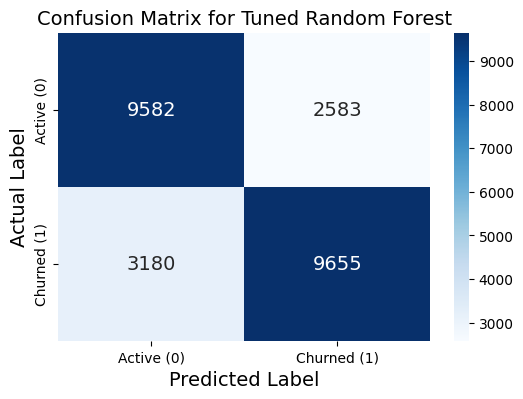

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     12165
           1       0.79      0.75      0.77     12835

    accuracy                           0.77     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.77      0.77      0.77     25000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


# Predict labels for the validation set
y_val_pred = best_rf_model.predict(X_val_raw)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Active (0)', 'Churned (1)'],
            yticklabels=['Active (0)', 'Churned (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Tuned Random Forest")
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

*   ROC Curve and AUC

ROC Curve: Illustrates the model's ability to distinguish between classes.

AUC Score: A higher value (closer to 1) indicates better performance.

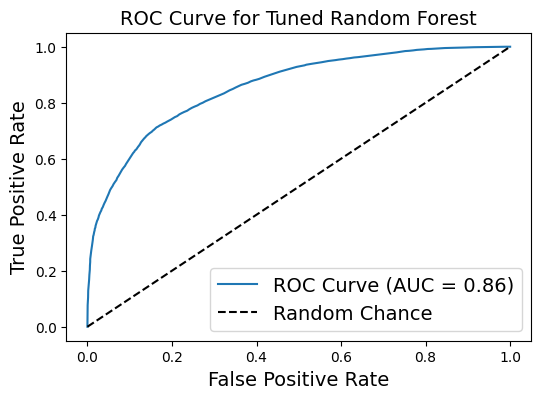

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (churned)
y_val_prob = best_rf_model.predict_proba(X_val_raw)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
auc_score = roc_auc_score(y_val, y_val_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Tuned Random Forest")
plt.legend()
plt.show()

*   Analyse Misclassified Samples

Examining misclassified samples (false negatives and false positives) help understand if certain customer segments or features are causing problems

In [ ]:
# Ensure X_val_raw is a DataFrame (if not, convert it with appropriate column names)
if not isinstance(X_val_raw, pd.DataFrame):
    X_val_raw = pd.DataFrame(X_val_raw, columns=preprocessor.get_feature_names_out())

# Create a Series for true labels and predicted labels for easy filtering
y_val_series = pd.Series(y_val.values, index=X_val_raw.index)
y_pred_series = pd.Series(y_val_pred, index=X_val_raw.index)

# Identify False Negatives: Actual churn (1) but predicted as active (0)
false_negatives = X_val_raw[(y_val_series == 1) & (y_pred_series == 0)]
print("Number of False Negatives (missed churn):", false_negatives.shape[0])
print(false_negatives.head())

# Identify False Positives: Actual active (0) but predicted as churn (1)
false_positives = X_val_raw[(y_val_series == 0) & (y_pred_series == 1)]
print("Number of False Positives (incorrectly predicted churn):", false_positives.shape[0])
print(false_positives.head())

Number of False Negatives (missed churn): 3180
             age  num_subscription_pauses  weekly_hours  \
111676  0.836066                      1.0      0.861784   
103313  0.901639                      1.0      0.380458   
14633   0.114754                      0.5      0.486732   
110750  0.311475                      1.0      0.345748   
18550   0.540984                      0.0      0.337407   

        average_session_length  song_skip_rate  weekly_songs_played  \
111676                0.401866        0.669037             0.522177   
103313                0.588518        0.110361             0.171371   
14633                 0.973200        0.890594             0.588710   
110750                0.939980        0.052887             0.125000   
18550                 0.984619        0.243256             0.927419   

        weekly_unique_songs  num_favorite_artists  num_platform_friends  \
111676             0.408784              0.102041              0.909548   
103313             0.

**Insights from error analysis:**

The tuned Random Forest model is reasonably balanced, with an accuracy near 77%.

The AUC of 0.86 indicates the model does a decent job separating churned vs. active customers across different probability thresholds.

However, the false negatives are still a significant business concern, indicates there are quite many actual churners predicted as active.

### Fine-tune Gradient Boosting Classifier

Gradient Boosting Classifier will be fine-tuned based on the following hyperparameters:


*   n-Estimators
*   Learning rate
*   Max-depth
*   Subsample

In [ ]:
from scipy.stats import uniform, randint
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Build a pipeline for Gradient Boosting that includes preprocessing
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # preprocessor expects raw data with original column names
    ('gradient_boosting', GradientBoostingClassifier(random_state=42))
])

In [ ]:
# Define parameter distributions for Gradient Boosting
param_distribs_gb = {
    'gradient_boosting__n_estimators': randint(50, 200),        # try between 50 and 200 trees
    'gradient_boosting__learning_rate': uniform(0.01, 0.19),      # learning_rate in the range [0.01, 0.2]
    'gradient_boosting__max_depth': randint(3, 10),               # tree depth from 3 to 9
    'gradient_boosting__subsample': uniform(0.7, 0.3)             # subsample ratio between 0.7 and 1.0
}

In [ ]:
# Set up RandomizedSearchCV (using 10 iterations and 3-fold CV)
gb_random_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_distribs_gb,
    n_iter=10,            # sample 10 different parameter combinations
    cv=3,                 # 3-fold cross-validation
    scoring='accuracy',   # using accuracy as the evaluation metric
    random_state=42,
    n_jobs=-1             # use all available CPU cores
)

In [ ]:
# Fit RandomizedSearchCV on the training portion of the raw data
# (X_train_raw and y_train are the raw training data split earlier)
gb_random_search.fit(X_train_raw, y_train)

print("Best parameters for Gradient Boosting:", gb_random_search.best_params_)
print("Best CV accuracy for Gradient Boosting:", gb_random_search.best_score_)

Best parameters for Gradient Boosting: {'gradient_boosting__learning_rate': 0.1262520499972521, 'gradient_boosting__max_depth': 4, 'gradient_boosting__n_estimators': 64, 'gradient_boosting__subsample': 0.8368209952651107}
Best CV accuracy for Gradient Boosting: 0.7822599726567253


In [ ]:
# Evaluate the tuned model on the validation set
best_gb_model = gb_random_search.best_estimator_
y_val_pred_gb = best_gb_model.predict(X_val_raw)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
validation_results_gb = {
    "Accuracy": accuracy_score(y_val, y_val_pred_gb),
    "Precision": precision_score(y_val, y_val_pred_gb),
    "Recall": recall_score(y_val, y_val_pred_gb),
    "F1-score": f1_score(y_val, y_val_pred_gb)
}

print("Validation Performance of Tuned Gradient Boosting:")
print(pd.DataFrame([validation_results_gb]))

Validation Performance of Tuned Gradient Boosting:
   Accuracy  Precision    Recall  F1-score
0   0.78088   0.823726  0.729256  0.773618


**Error Analysis of Gradient Boosting Classifier:**

This analysis aims to understand where the tuned gradient boosting model is failing. It includes


* Confusion Matrix & Classification Report

The confusion matrix shows the breakdown of correct and incorrect predictions (true positives, false positives, etc.).

The classification report provides precision, recall, and F1-score for each class.

Confusion Matrix (Gradient Boosting):
 [[10162  2003]
 [ 3475  9360]]


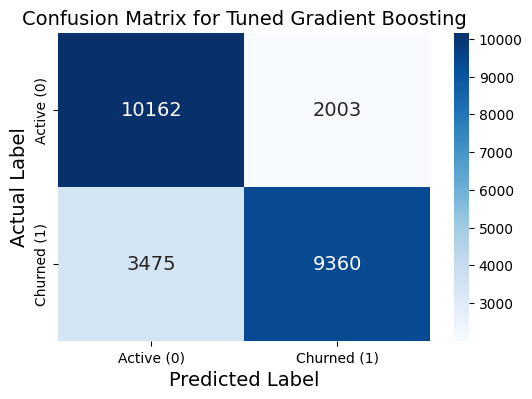

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     12165
           1       0.82      0.73      0.77     12835

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.79      0.78      0.78     25000



In [ ]:
# Predict on the validation set using the tuned Gradient Boosting model
y_val_pred_gb = best_gb_model.predict(X_val_raw)

# Compute confusion matrix
cm_gb = confusion_matrix(y_val, y_val_pred_gb)
print("Confusion Matrix (Gradient Boosting):\n", cm_gb)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Active (0)', 'Churned (1)'],
            yticklabels=['Active (0)', 'Churned (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Tuned Gradient Boosting")
plt.show()

# Classification report
print("Classification Report (Gradient Boosting):")
print(classification_report(y_val, y_val_pred_gb))

*   ROC Curve and AUC

ROC Curve: Illustrates the model's ability to distinguish between classes.

AUC Score: A higher value (closer to 1) indicates better performance.

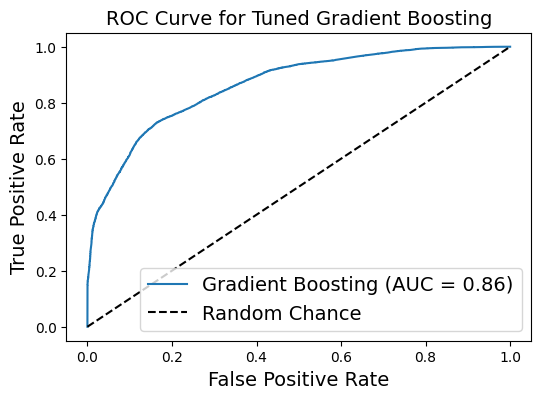

In [ ]:
# Get predicted probabilities for the positive class (churn)
y_val_prob_gb = best_gb_model.predict_proba(X_val_raw)[:, 1]

# Compute ROC curve and AUC
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_val, y_val_prob_gb)
auc_gb = roc_auc_score(y_val, y_val_prob_gb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Tuned Gradient Boosting")
plt.legend()
plt.show()

*   Analyse Misclassified Samples

Examining misclassified samples (false negatives and false positives) help understand if certain customer segments or features are causing problems

In [ ]:
y_val_pred_series_gb = pd.Series(y_val_pred_gb, index=X_val_raw.index)

# False Negatives: Actual churn (1) but predicted as active (0)
false_negatives_gb = X_val_raw[(y_val == 1) & (y_val_pred_series_gb == 0)]
print("Number of False Negatives (missed churn):", false_negatives_gb.shape[0])
print(false_negatives_gb.head())

# False Positives: Actual active (0) but predicted as churn (1)
false_positives_gb = X_val_raw[(y_val == 0) & (y_val_pred_series_gb == 1)]
print("Number of False Positives (incorrectly predicted churn):", false_positives_gb.shape[0])
print(false_positives_gb.head())

Number of False Negatives (missed churn): 3475
             age  num_subscription_pauses  weekly_hours  \
111676  0.836066                     1.00      0.861784   
103313  0.901639                     1.00      0.380458   
14633   0.114754                     0.50      0.486732   
104877  0.475410                     0.25      0.995628   
110750  0.311475                     1.00      0.345748   

        average_session_length  song_skip_rate  weekly_songs_played  \
111676                0.401866        0.669037             0.522177   
103313                0.588518        0.110361             0.171371   
14633                 0.973200        0.890594             0.588710   
104877                0.364260        0.950800             0.469758   
110750                0.939980        0.052887             0.125000   

        weekly_unique_songs  num_favorite_artists  num_platform_friends  \
111676             0.408784              0.102041              0.909548   
103313             0.

**Insights from error analysis with comparative view:**

To sum up,

*Random Forest*

FN = 3180, FP = 2583, ~77% accuracy, recall for churn ~75%, precision for churn ~79%.

*Gradient Boosting*

FN = 3475, FP = 2003, ~78% accuracy, recall for churn ~73%, precision for churn ~82%.

The comparison of error analysis result above shows:

Gradient Boosting has fewer false positives but more false negatives, which means higher precision but slightly lower recall for churn.

Random Forest has more false positives but fewer false negatives, which means slightly lower precision but higher recall for churn.

# Neural Network Model Training

## Build A Simple Neural Network Model: MLP

**Import Libraries and Set Seeds**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

**Define the MLP Model**

Here, I create a function to build a simple MLP.

The network has two hidden layers and one output layer with a sigmoid activation (suitable for binary classification).

In [ ]:
def create_mlp_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  # Explicitly define the input layer
        Dense(64, activation='relu'),  # First hidden layer with 64 neurons and ReLU activation.
        Dense(32, activation='relu'), # Second hidden layer with 32 neurons.
        Dense(1, activation='sigmoid') # Sigmoid outputs a probability between 0 and 1 for the binary target
    ])
    return model

# Create the model using the number of input features from transformed data
input_dim = X_train_transformed.shape[1]
mlp_model = create_mlp_model(input_dim)
mlp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

**Compile the Model**

Compile the model with an optimizer, loss function, and metrics.

For binary classification, we use binary cross-entropy loss.

In [ ]:
mlp_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

**Train the Model**

Train the model on the training data.

Use the validation split to monitor performance.

In [ ]:
history = mlp_model.fit(
    X_train, y_train,           # Use split training set
    epochs=50,                  # Number of complete passes through training data
    batch_size=32,              # Number of samples per gradient update
    validation_data=(X_val, y_val),  # Use validation set for evaluation during training
    verbose=1
)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7205 - loss: 0.5442 - val_accuracy: 0.7494 - val_loss: 0.5020
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7520 - loss: 0.5000 - val_accuracy: 0.7563 - val_loss: 0.4923
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7568 - loss: 0.4910 - val_accuracy: 0.7591 - val_loss: 0.4868
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7599 - loss: 0.4861 - val_accuracy: 0.7612 - val_loss: 0.4834
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7611 - loss: 0.4829 - val_accuracy: 0.7634 - val_loss: 0.4812
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7627 - loss: 0.4802 - val_accuracy: 0.7644 - val_loss: 0.4792
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7643 - loss: 0.4775 - val_accuracy: 0.7654 - val_loss: 0.4776
Epoch 8/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7658 - loss: 0.475

**Evaluate the Model on the Validation Set**

In [ ]:
val_loss, val_accuracy = mlp_model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7649 - loss: 0.4736
Validation Loss: 0.47042471170425415
Validation Accuracy: 0.7683200240135193


Neural network model is showing a validation accuracy of about 76.83% with a loss of roughly 0.47.

Interpretation:

Validation Accuracy (~76.8%):

The model correctly predicts whether a user will churn about 76.8% of the time on unseen data. This is comparable to baseline models (e.g., Logistic Regression, Random Forest, and Gradient Boosting), indicating that even a simple MLP can capture useful patterns in the data.

Validation Loss (~0.47):

The loss is computed using binary cross-entropy. It is moderate.

A lower loss generally indicates better calibration of the predicted probabilities. Combined with accuracy, it suggests that the network is learning effectively.

## Fine-tune MLP Model

Method 1: Changing the Architecture

I experiment with adding extra hidden layers or increasing the number of neurons to help reduce potential overfitting.

With codes below I update MLP to have more neurons, additional hidden layers, and insert dropout layers for regularisation.

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_mlp_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),                # Explicit input layer
        Dense(128, activation='relu',             # Increase neurons from 64 to 128
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),                              # Dropout for regularization
        Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')              # Output layer for binary classification
    ])
    return model

# Use transformed training data to get input dimension
input_dim = X_train_transformed.shape[1]
mlp_model = create_mlp_model(input_dim)
mlp_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Method 2: Adjusting Hyperparameters

I adjust the learning rate, batch size, and epochs.

In particular, I use callbacks like EarlyStopping can help prevent overfitting and save training time.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model with a specific learning rate
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Set up early stopping to monitor validation loss and restore the best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the transformed training and validation data
history = mlp_model.fit(
    X_train, y_train,
    epochs=100,                # early stopping will halt training when appropriate
    batch_size=32,             # Adjust batch size if needed
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7567 - loss: 0.5004 - val_accuracy: 0.7657 - val_loss: 0.4858
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7587 - loss: 0.4983 - val_accuracy: 0.7662 - val_loss: 0.4857
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7595 - loss: 0.4995 - val_accuracy: 0.7683 - val_loss: 0.4873
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7608 - loss: 0.4997 - val_accuracy: 0.7670 - val_loss: 0.4879
Epoch 5/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7591 - loss: 0.4992 - val_accuracy: 0.7697 - val_loss: 0.4880
Epoch 6/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7587 - loss: 0.4992 - val_accuracy: 0.7686 - val_loss: 0.4879
Epoch 7/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7588 - loss: 0.4998 - val_accuracy: 0.7661 - val_loss: 0.4894


Insights:

The model has learned reasonably well.

The gap between training and validation metrics is small, indicating low overfitting.

Performance Plateau:

The improvements from epoch to epoch are now very small. This indicates that the learning has slowed down, and the model might be approaching a plateau.

Therefore, here I finetune further by:

Reduce the learning rate automatically when the validation loss plateaus.

Also use early stopping to prevent overfitting and to restore the best weights.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks:
#  - ReduceLROnPlateau will reduce the learning rate by a factor of 0.5 if the validation loss doesn't improve for 3 epochs.
#  - EarlyStopping will stop training if validation loss doesn't improve for 5 epochs and restore the best weights.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Fine-tune the MLP model for additional epochs
history_finetune = mlp_model.fit(
    X_train, y_train,                  # Using transformed training data from the split
    epochs=50,                         # Additional epochs for fine-tuning
    batch_size=32,                     # Batch size can remain as before
    validation_data=(X_val, y_val),     # Use validation data to monitor performance
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7589 - loss: 0.5016 - val_accuracy: 0.7645 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7570 - loss: 0.5029 - val_accuracy: 0.7672 - val_loss: 0.4881 - learning_rate: 0.0010
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7600 - loss: 0.4987 - val_accuracy: 0.7655 - val_loss: 0.4910 - learning_rate: 0.0010
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7607 - loss: 0.5003 - val_accuracy: 0.7653 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 5/50
3107/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7595 - loss: 0.5011
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7595 - loss: 0.5011 - val_accuracy: 0.7670 - val_loss: 0.4891 - learning_rate: 0.0010
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7614 - lo

Method 3: Incorporating Regularization Techniques

Based on dropout and L2 regularisation in method 1, I experiment further.

I add Batch Normalization layers to improve generalisation. Batch Normalization helps stabilise and accelerate training by normalizing the inputs of each layer.

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def create_mlp_model_with_batchnorm(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),                    # Batch normalization layer
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create the model with batch normalization
mlp_model_bn = create_mlp_model_with_batchnorm(input_dim)
mlp_model_bn.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
mlp_model_bn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 384 (1.50 KB)

Performance

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# 1. Generate predicted probabilities
y_val_pred_prob = mlp_model.predict(X_val)

# 2. Convert probabilities to binary class predictions (threshold=0.5)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# 3. Compute basic metrics
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Fine-tuned MLP Performance on Validation Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fine-tuned MLP Performance on Validation Set:
Accuracy:  0.7676
Precision: 0.7837
Recall:    0.7561
F1-score:  0.7697


## Error Analysis of Fine-tuned MLP

Generate predictions on the validation set.

In [ ]:
# (Assuming X_val is a DataFrame and y_val is available)
y_val_pred_prob = mlp_model.predict(X_val)
# Convert predicted probabilities to binary predictions using 0.5 threshold
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Confusion Matrix and Classification Report

Confusion Matrix (Gradient Boosting Fine-tuned MLP):
[[9409 2756]
 [2988 9847]]


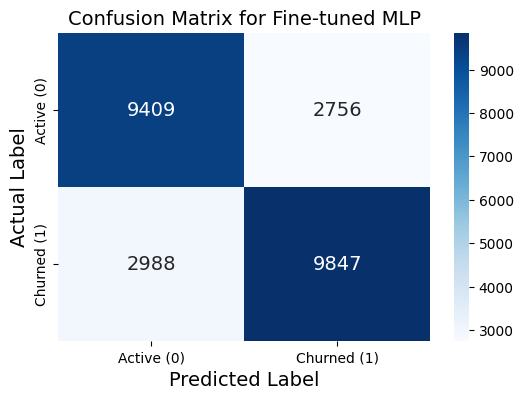


Classification Report (Fine-tuned MLP):
              precision    recall  f1-score   support

           0       0.76      0.77      0.77     12165
           1       0.78      0.77      0.77     12835

    accuracy                           0.77     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.77      0.77      0.77     25000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix (Gradient Boosting Fine-tuned MLP):")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Active (0)', 'Churned (1)'],
            yticklabels=['Active (0)', 'Churned (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Fine-tuned MLP")
plt.show()

print("\nClassification Report (Fine-tuned MLP):")
print(classification_report(y_val, y_val_pred))

 ROC Curve and AUC

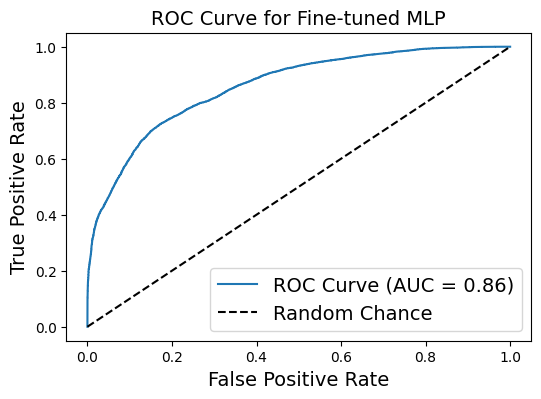

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
auc_score = roc_auc_score(y_val, y_val_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fine-tuned MLP")
plt.legend(loc="lower right")
plt.show()

Misclassified Cases Analysis

In [ ]:
# Convert y_val and predictions to 1D arrays for indexing
y_val_array = np.array(y_val)
y_val_pred_array = y_val_pred.flatten()

# False Negatives: Actual churners (1) predicted as active (0)
fn_indices = np.where((y_val_array == 1) & (y_val_pred_array == 0))[0]
# False Positives: Actual active (0) predicted as churn (1)
fp_indices = np.where((y_val_array == 0) & (y_val_pred_array == 1))[0]

print("Number of False Negatives (missed churn):", len(fn_indices))
print("Number of False Positives (incorrectly predicted churn):", len(fp_indices))

# If X_val is a DataFrame, display a few misclassified samples
# (If it's an array, you can convert it to a DataFrame using the same column names as before)
if isinstance(X_val, pd.DataFrame):
    print("\nExamples of False Negatives:")
    print(X_val.iloc[fn_indices].head())
    print("\nExamples of False Positives:")
    print(X_val.iloc[fp_indices].head())
else:
    print("X_val is not a DataFrame; consider converting it to inspect misclassified cases.")

Number of False Negatives (missed churn): 2988
Number of False Positives (incorrectly predicted churn): 2756

Examples of False Negatives:
        num__age  num__num_subscription_pauses  num__weekly_hours  \
103313  0.901639                          1.00           0.465147   
14633   0.114754                          0.50           0.572144   
104877  0.475410                          0.25           0.996843   
110750  0.311475                          1.00           0.428409   
18550   0.540984                          0.00           0.419439   

        num__average_session_length  num__song_skip_rate  \
103313                     0.588518             0.151029   
14633                      0.973200             0.918840   
104877                     0.364260             0.964066   
110750                     0.939980             0.074351   
18550                      0.984619             0.314124   

        num__weekly_songs_played  num__weekly_unique_songs  \
103313                 

Insights from Error Analysis

# Performance Comparison of Fine-tuned Baseline Models and Neural Network Model

To gain insights from model training and fine-tuning, I here present a clearer gathering of key metrics and visualise to justify model selection.

In [ ]:
model_performance = {
    'Random Forest': {
        'Accuracy': 0.769,
        'Precision': 0.789,
        'Recall': 0.752,
        'F1-score': 0.770,
        'AUC': 0.86
    },
    'Gradient Boosting': {
        'Accuracy': 0.781,
        'Precision': 0.824,
        'Recall': 0.729,
        'F1-score': 0.774,
        'AUC': 0.86
    },
    'Fine-tuned MLP': {
        'Accuracy': 0.770,
        'Precision': 0.781,
        'Recall': 0.767,
        'F1-score': 0.774,
        'AUC': 0.86
    }
}

In [ ]:
df_results = pd.DataFrame(model_performance).T  # transpose so models become rows
df_results

,Accuracy,Precision,Recall,F1-score,AUC
Random Forest,0.769,0.789,0.752,0.770,0.86
Gradient Boosting,0.781,0.824,0.729,0.774,0.86
Fine-tuned MLP,0.770,0.781,0.767,0.774,0.86


To visualise and compare:

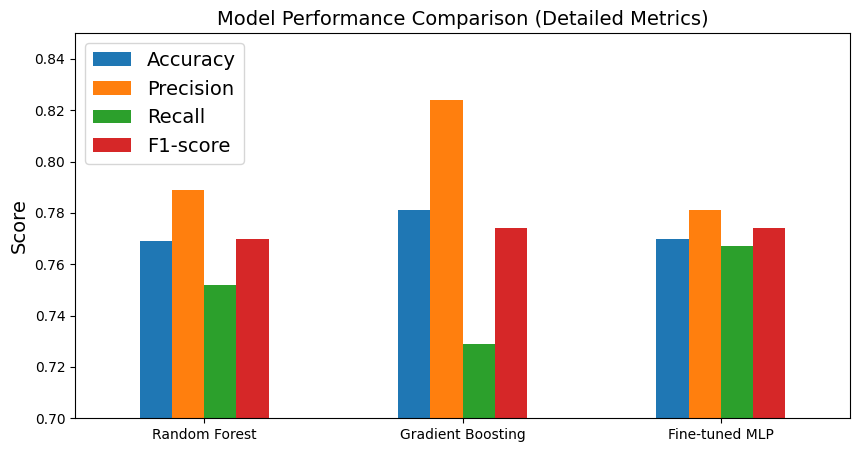

In [ ]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score']
df_results[metrics_to_plot].plot(kind='bar', figsize=(10, 5), ylim=(0.7, 0.85))
plt.title("Model Performance Comparison (Detailed Metrics)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.show()

Though MLP does not perform the best at all metrics, it is the most balanced and achieved highest recall and F1-score.

Identify Top Performers: Which model has the highest accuracy or best F1-score?
Precision vs. Recall: Check if any model leans towards high precision or high recall.
AUC: If all have ~0.86 AUC, they’re similarly capable at ranking positive vs. negative cases.

## Exploring Ensembling Gradient Boosting and MLP

Which one to choose?

Gradient Boosting has the highest accuracy and precision, meaning it’s slightly better at not flagging non-churners as churners (fewer false positives).

MLP shows a slightly higher recall, meaning it catches a bit more of the actual churners (fewer false negatives).

F1-scores and AUC are very similar across models.


If precision is more critical (e.g., you want to avoid unnecessary retention efforts on active users), Gradient Boosting might be preferable.
If recall is more important (e.g., missing a churner is very costly), then the MLP might be better.


Given that the differences are marginal, I explore ensembling the Gradient Boosting and MLP models to leverage their individual strengths.

A simple ensembling approach is to average the predicted probabilities from both models and then threshold the average to generate the final prediction.

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Ensemble Performance on Validation Set:
Accuracy:  0.775
Precision: 0.807
Recall:    0.739
F1-score:  0.772
AUC:       0.861


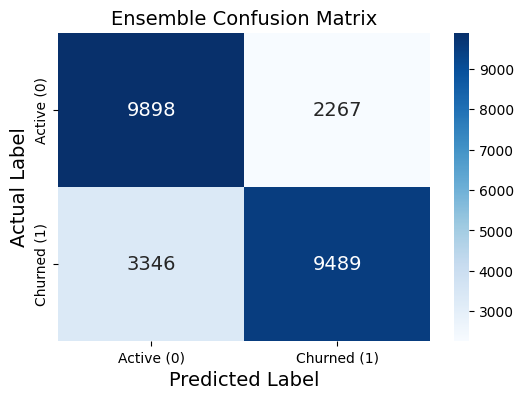


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     12165
           1       0.81      0.74      0.77     12835

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



In [ ]:
# Get predicted probabilities from Gradient Boosting (probability of class 1)
gb_probs = gb_clf.predict_proba(X_val)[:, 1]

# Get predicted probabilities from the MLP (make sure to flatten the output)
mlp_probs = mlp_model.predict(X_val).flatten()

# Combine predictions with equal weighting
ensemble_probs = (gb_probs + mlp_probs) / 2

# Convert ensemble probabilities to class labels using a threshold of 0.5
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(y_val, ensemble_preds)
ensemble_precision = precision_score(y_val, ensemble_preds)
ensemble_recall = recall_score(y_val, ensemble_preds)
ensemble_f1 = f1_score(y_val, ensemble_preds)
ensemble_auc = roc_auc_score(y_val, ensemble_probs)

print("Ensemble Performance on Validation Set:")
print(f"Accuracy:  {ensemble_accuracy:.3f}")
print(f"Precision: {ensemble_precision:.3f}")
print(f"Recall:    {ensemble_recall:.3f}")
print(f"F1-score:  {ensemble_f1:.3f}")
print(f"AUC:       {ensemble_auc:.3f}")

# Optional: Plot a confusion matrix for the ensemble
cm = confusion_matrix(y_val, ensemble_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Active (0)', 'Churned (1)'],
            yticklabels=['Active (0)', 'Churned (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Ensemble Confusion Matrix")
plt.show()

# Optional: Display a classification report
print("\nClassification Report:")
print(classification_report(y_val, ensemble_preds))


Insights:

Combining Gradient Boosting and the fine-tuned MLP resulted in slightly improved precision and a balanced F1-score compared to the individual models.



Apply the ensemble (which averages the predictions of Gradient Boosting and the fine-tuned MLP) on the test dataset, generates predictions, and saves them to a CSV file.

In [ ]:
# Generate predictions on the test set using the ensemble approach
# For Gradient Boosting and Random Forest models, they output class probabilities via predict_proba,
# while the MLP outputs probabilities directly.
gb_test_prob = gb_clf.predict_proba(X_test_transformed)[:, 1]  # probability for class 1 from Gradient Boosting
mlp_test_prob = mlp_model.predict(X_test_transformed).flatten()    # probability for class 1 from MLP

# Combine predictions by averaging them (equal weighting)
ensemble_test_prob = (gb_test_prob + mlp_test_prob) / 2

# Convert averaged probabilities to binary class predictions using a threshold of 0.5
ensemble_test_pred = (ensemble_test_prob > 0.5).astype(int)

# Create a DataFrame to store test predictions
test_predictions = pd.DataFrame({
    'id': test_df.index,             # Assuming your test DataFrame has an index or an id column
    'churn_prediction': ensemble_test_pred,
    'churn_probability': ensemble_test_prob
})

print("Test predictions generated. Sample output:")
print(test_predictions.head())

# Optionally, save the predictions to a CSV file for submission or further analysis
test_predictions.to_csv("test_predictions.csv", index=False)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Test predictions generated. Sample output:
   id  churn_prediction  churn_probability
0   0                 0           0.416081
1   1                 0           0.479029
2   2                 0           0.402760
3   3                 0           0.482156
4   4                 1           0.687608
